# Compologicircuits.jl
A functional and compositional language for building logic circuits using Catlab.jl. Includes applications to sub-circuit picking and SAT.

In [44]:
using Catlab.Programs
using Catlab.WiringDiagrams
using Catlab.Present
using Catlab.Theories
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.CategoricalAlgebra
using Catlab.Syntax
using Catlab.GAT
import Catlab.Theories: dom, codom, id, compose, otimes, braid, munit, mcopy, delete, pair, proj1, proj2, ⊗, ⋅, σ
using MLStyle
using Test

show_diagram (generic function with 1 method)

In [ ]:
# Helper function to show graphviz diagrams
show_diagram(d::WiringDiagram) = to_graphviz(
    add_junctions(d),
    orientation=LeftToRight,
    labels=false, label_attr=:xlabel,
    node_attrs=Graphviz.Attributes(
        :fontname => "Courier",
    ),
    edge_attrs=Graphviz.Attributes(
        :fontname => "Courier",
    )
)

## Logic circuits as morphisms in a Cartesian Monoidal Category

### Motivation

When building complex circuits, the ability to encapsulate subcircuits into reusable abstractions is imperative. The ability to compose circuits in both sequence and parallel is also desirable.

### Background

Representing logical circuits as string diagrams in a Cartesian Category provides a rich compositional language for building circuits functionally and composing these circuits hierachically, sequentially, and in parallel. Operadic composition captures subcircuit abstraction while composition and monoidal product of morphisms capture the sequential and parallel composition of circuits. A cartesian category is used to provide natural notions of copying and deletion of wires, which is often used in circuit diagrams.   

First, we need a presentation of the basic objects and homs in our category of logic circuits. The fundamental object is Bool and the basic morphisms or gates are AND, OR, and NOT.

In [3]:
@present Circuits(FreeCartesianCategory) begin
    B::Ob
    NOT::Hom(B,B)
    AND::Hom(B⊗B,B)
    OR::Hom(B⊗B,B)
end

Presentation{CartesianCategory, Symbol}(Catlab.Theories.FreeCartesianCategory, (Ob = Catlab.Theories.FreeCartesianCategory.Ob{:generator}[B], Hom = Catlab.Theories.FreeCartesianCategory.Hom{:generator}[NOT, AND, OR]), Dict(:NOT => (:Hom => 1), :B => (:Ob => 1), :AND => (:Hom => 2), :OR => (:Hom => 3)), Pair[])

Now, we can define more complicated circuits using the ```Circuits``` DSL which the Catlab ```@program``` macro automatically generates. Here is an example of building an XOR circuit. We can view this circuit as both a wiring diagram and a syntactic expression.

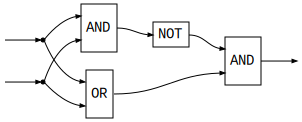

In [4]:
#Wiring Diagram representation of XOR
XOR = @program Circuits (x::B, y::B) begin
    xnandy = NOT(AND(x,y))
    xory = OR(x,y)
    return AND(xnandy,xory)
end

show_diagram(XOR)

In [5]:
XOR_expr = to_hom_expr(FreeCartesianCategory, XOR)

(mcopy{B}⊗mcopy{B})⋅(id{B}⊗braid{B,B}⊗id{B})⋅((AND⋅NOT)⊗OR)⋅AND: B⊗B → B

## Logic circuit semantics as an instance of a Cartesian Monoidal Category

### Motivation

We now want to provide a way to actually simulate the circuit diagrams we have been creating. Essentially, we have specified the *syntax* of circuit diagrams, now we want to specify some *semantics*

### Background

Using the Catlab ```@instance``` macro, we can explicitly specify how circuits should compose as morphisms in a CMC. 

First, we need to define a basic julia type to store our circuits:

In [6]:
# The skeleton of n-dimensional bool spaces which are the input/output types of logic circuits
struct CircuitDom
    n::Int
end

# Implement a logic circuit as a function from Vector{Bool} to Vector{Bool}
struct Circuit
    dom::CircuitDom
    codom::CircuitDom
    impl::Function # Vector{Bool} of size dom -> Vector{Bool} of size codom
end

# Convenience constructor
Circuit(nins::Int, nouts::Int, impl) = Circuit(CircuitDom(nins), CircuitDom(nouts), impl)

# Apply a circuit to the specified input vector
apply(circuit::Circuit, input::Vector{Bool})::Vector{Bool} = circuit.impl(input)

apply (generic function with 1 method)

We can use the Circuit struct to define implementations of the basic logic gates we were using earlier:

In [7]:
# Basic logic gate implementations
iNOT = Circuit(1, 1, x->[!x[1]])

iAND = Circuit(2, 1, x->[x[1] && x[2]])

iOR = Circuit(2, 1, x->[x[1] || x[2]])

Circuit(CircuitDom(2), CircuitDom(1), var"#5#6"())

Now we can use these types to specify a CMC instance:

In [8]:
# Make circuits compositional by implementing them as an CMC instance
@instance CartesianCategory{CircuitDom, Circuit} begin
    id(A::CircuitDom) = Circuit(A,A, x->x)
    dom(f::Circuit) = f.dom
    codom(f::Circuit) = f.codom

    # Circuit composition is just function composition
    compose(f::Circuit, g::Circuit) = begin
        @assert(f.codom == g.dom)
        return Circuit(f.dom, g.codom, x->g.impl(f.impl(x)))
    end

    otimes(A::CircuitDom, B::CircuitDom) = CircuitDom(A.n + B.n)
    # Monoidal product of circuits runs both circuits and concatenates the results
    otimes(f::Circuit, g::Circuit) = begin
        impl = x -> vcat(f.impl(x[1:f.dom.n]), g.impl(x[f.dom.n + 1:end]))
        return Circuit(f.dom.n + g.dom.n, f.codom.n + g.codom.n, impl)
    end

    # A symmetric braiding just swaps the A and B parts of the input vector
    braid(A::CircuitDom, B::CircuitDom) = begin
        impl = x -> vcat(x[A.n+1:end], x[1:A.n])
        n = A.n + B.n
        Circuit(n, n, impl)
    end

    # Monoidal unit is a 0-dimensional bool space (i.e. a point or empty list)
    munit(::Type{CircuitDom}) = CircuitDom(0)

    # Cartesian Category bells and whistles
    mcopy(A::CircuitDom) = Circuit(A.n, A.n+A.n, x->vcat(x,x))
    delete(A::CircuitDom) = Circuit(A.n, 0, x->Bool[])

    pair(f::Circuit, g::Circuit) = begin
        @assert(f.dom == g.dom)
        return Circuit(f.dom.n, f.codom.n+g.codom.n, x->vcat(f.impl(x), g.impl(x)))
    end
    proj1(A::CircuitDom, B::CircuitDom) = Circuit(A.n+B.n, A.n, x->x[1:A.n])
    proj2(A::CircuitDom, B::CircuitDom) = Circuit(A.n+B.n, B.n, x->x[A.n+1:end])
end

### Functor from Syntax to Semantics

We now want to see the circuit semantics in action. Catlab makes it easy to define a functor which maps syntactic morphism expressions in a category (or any GAT) to corresponding morphisms in an instance of that category:

In [9]:
# Functor from circuit diagrams to circuit implementations
gens = Dict(
    Circuits[:B]=>CircuitDom(1), 
    Circuits[:NOT]=>iNOT, 
    Circuits[:AND]=>iAND, 
    Circuits[:OR]=>iOR
)
Impl(expr) = functor((CircuitDom, Circuit), expr, generators=gens)

Impl (generic function with 1 method)

Lets see how this functor works on the XOR expression constructed earlier

In [10]:
#Implement XOR diagram
iXOR = Impl(XOR_expr)
#Print XOR truth table
for i in Iterators.product([false, true], [false, true])
    input = collect(i)
    output = apply(iXOR, input)
    println("XOR on $input = $output")
end

XOR on Bool[0, 0] = Bool[0]
XOR on Bool[1, 0] = Bool[1]
XOR on Bool[0, 1] = Bool[1]
XOR on Bool[1, 1] = Bool[0]


Now we can go crazy! First, lets extend our Circuit DSL with abstractions for XOR and full adders.

In [11]:
@present MoreCircuits <: Circuits begin
    XOR::Hom(B⊗B,B)
    FA::Hom(B⊗B⊗B,B⊗B)
end

Presentation{CartesianCategory, Symbol}(Catlab.Theories.FreeCartesianCategory, (Ob = Catlab.Theories.FreeCartesianCategory.Ob{:generator}[B], Hom = Catlab.Theories.FreeCartesianCategory.Hom{:generator}[NOT, AND, OR, XOR, FA]), Dict(:NOT => (:Hom => 1), :FA => (:Hom => 5), :B => (:Ob => 1), :AND => (:Hom => 2), :OR => (:Hom => 3), :XOR => (:Hom => 4)), Pair[])

We can define a full adder diagram using the intermediate abstraction of XOR along with our original basic gates: 

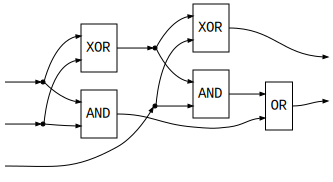

In [12]:
full_adder = @program MoreCircuits (x::B, y::B, cin::B) begin
    z = XOR(x,y)
    s = XOR(z,cin)
    cout = OR(AND(z,cin),AND(x,y))
    return (s, cout)
end

show_diagram(full_adder)

And now, operadic composition allows us to substitute the XOR boxes with full XOR diagrams in terms of the basic gates:

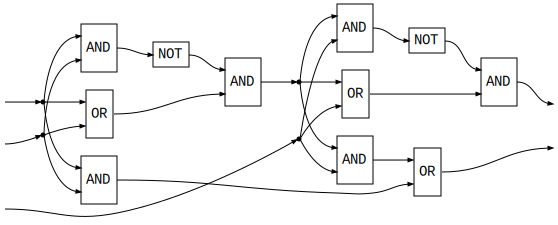

In [14]:
AND = to_wiring_diagram(MoreCircuits[:AND])
NOT = to_wiring_diagram(MoreCircuits[:NOT])
OR = to_wiring_diagram(MoreCircuits[:OR])
total_full_adder = ocompose(full_adder, [XOR, XOR, AND, AND, OR])
show_diagram(total_full_adder)

In [42]:
# Implement the full adder diagram
iFA = Impl(to_hom_expr(FreeCartesianCategory, total_full_adder))

# Print Full Adder truth table
for i in Iterators.product([false, true], [false, true], [false, true])
    input = collect(i)
    output = apply(iFA, input)
    println("FA on $input = $output")
end

FA on Bool[0, 0, 0] = Bool[0, 0]
FA on Bool[1, 0, 0] = Bool[1, 0]
FA on Bool[0, 1, 0] = Bool[1, 0]
FA on Bool[1, 1, 0] = Bool[0, 1]
FA on Bool[0, 0, 1] = Bool[1, 0]
FA on Bool[1, 0, 1] = Bool[0, 1]
FA on Bool[0, 1, 1] = Bool[0, 1]
FA on Bool[1, 1, 1] = Bool[1, 1]


Finally, let's define and implement a 4-bit ripple-carry adder using the same technique of intermediate abstraction as above:

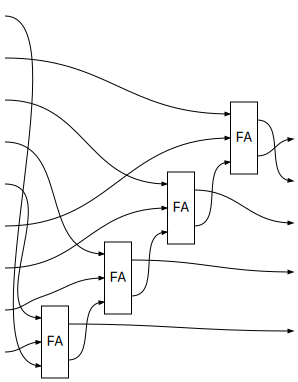

In [43]:
four_bit_adder = @program MoreCircuits (cin::B, x1::B, x2::B, x3::B, x4::B, y1::B, y2::B, y3::B, y4::B) begin
    s1, cout1 = FA(x4,y4,cin)
    s2, cout2 = FA(x3,y3,cout1)
    s3, cout3 = FA(x2,y2,cout2)
    s4, cout = FA(x1,y1,cout3)
    return (cout, s4, s3, s2, s1)
end

show_diagram(four_bit_adder)

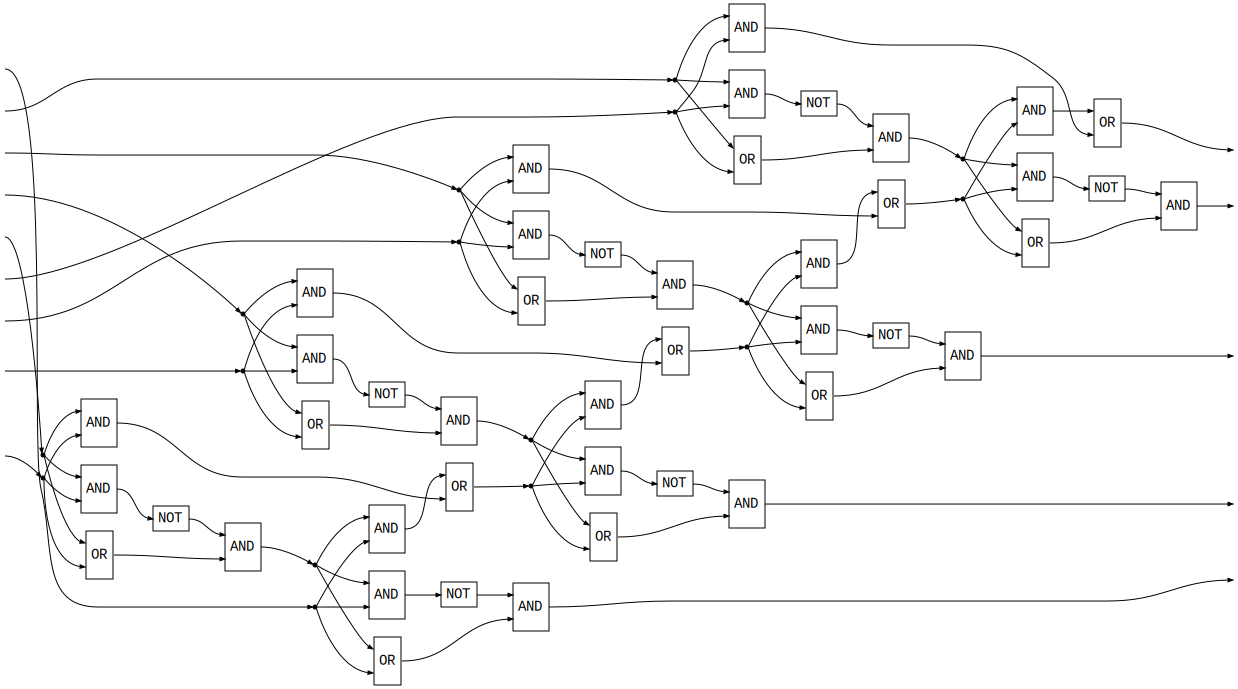

In [17]:
total_four_bit_adder = ocompose(four_bit_adder, [total_full_adder, total_full_adder, total_full_adder, total_full_adder])
show_diagram(total_four_bit_adder)

In [45]:
tfba_expr = to_hom_expr(FreeCartesianCategory, total_four_bit_adder)
# Implement the 4-bit adder
i4bitadder = Impl(tfba_expr)

# Do some addition
sum = apply(i4bitadder, 
    Bool[0,      #carry in
        0,1,1,1, #x=7
        0,1,1,0] #y=6
)

# Test that 7+6=13
@test sum == [0,1,1,0,1]

Test Passed
  Expression: sum == [0, 1, 1, 0, 1]
   Evaluated: Bool[0, 1, 1, 0, 1] == [0, 1, 1, 0, 1]

## Sub-Circuit Picking

### Motivation

Imagine that your company X-Corp has implemented a circuit design for some product. A sales-person from Y-Corp is advertising their circuit product, claiming that your board could use their product as a sub-circuit module. How do you verify this claim?

### Background

We define the problem of finding a sub-circuit *Y* in some circuit *X* as finding natural transformations from *Y* to *X*. However, for the purposes of finding sub-circuits, we must treat wires at the edge of the circuit the same way as we treat wires on the inside of a circuit. That is, we must define a functor from this simpler type of wiring diagram to our regular wiring diagram. We then take the DeltaMigration of this functor, which gives us a so-called ``forgetful'' functor from the wiring diagram ACSets that we are used to to these simpler wiring diagram ACSets. We can then then use this forgetful functor on our circuit diagrams to simplify them. We can then use Catlab's homomorphisms function to find sub-circuits for us.

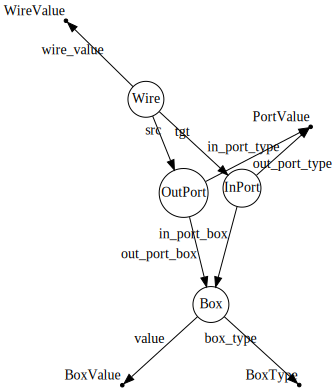

In [19]:
@present TheoryNotOpenWiringDiagram(FreeSchema) begin
    Box::Ob
    (InPort, OutPort)::Ob
    Wire::Ob

    # Finding sub-circuits must work whether the sub-circuit is located on the inside or on the edge of the larger circuit.
    #(OuterInPort, OuterOutPort)::Ob
    #(InWire, OutWire)::Ob

    PortValue::AttrType
    WireValue::AttrType
    BoxValue::AttrType
    BoxType::AttrType

    # To which in/out port is a wire attached?
    src::Hom(Wire, OutPort)
    tgt::Hom(Wire, InPort)

    in_port_type::Attr(InPort, PortValue)
    out_port_type::Attr(OutPort, PortValue)

    value::Attr(Box, BoxValue)
    box_type::Attr(Box, BoxType)
    wire_value::Attr(Wire, WireValue)
    #in_wire_value::Attr(InWire, WireValue)
    #out_wire_value::Attr(OutWire, WireValue)

    #in_tgt::Hom(InWire, InPort)
    #out_src::Hom(OutWire, OutPort)

    # To which box is an in/out port attached?
    in_port_box::Hom(InPort, Box)
    out_port_box::Hom(OutPort, Box)
end

to_graphviz(TheoryNotOpenWiringDiagram)

In [20]:
F = @finfunctor TheoryNotOpenWiringDiagram DirectedWiringDiagrams.TheoryAttributedWiringDiagram begin
    Box => Box
    InPort => InPort
    OutPort => OutPort
    Wire => Wire

    PortValue => PortValue
    WireValue => WireValue
    BoxValue => BoxValue
    BoxType => BoxType

    src => src
    tgt => tgt

    in_port_type => in_port_type
    out_port_type => out_port_type

    value => value
    box_type => box_type
    wire_value => wire_value

    in_tgt => in_tgt
    out_src => out_src

    in_port_box => in_port_box
    out_port_box => out_port_box
end

FinFunctor(Dict{Symbol, GATExpr{:generator}}(:InPort => InPort, :WireValue => WireValue, :Wire => Wire, :PortValue => PortValue, :BoxType => BoxType, :Box => Box, :BoxValue => BoxValue, :OutPort => OutPort), Dict{Symbol, GATExpr{:generator}}(:src => src, :value => value, :in_port_box => in_port_box, :wire_value => wire_value, :out_port_box => out_port_box, :box_type => box_type, :in_port_type => in_port_type, :tgt => tgt, :out_port_type => out_port_type), FinCat(Presentation{Schema, Symbol}(Catlab.Theories.FreeSchema, (Ob = Catlab.Theories.FreeSchema.Ob{:generator}[Box, InPort, OutPort, Wire], Hom = Catlab.Theories.FreeSchema.Hom{:generator}[src, tgt, in_port_box, out_port_box], AttrType = Catlab.Theories.FreeSchema.AttrType{:generator}[PortValue, WireValue, BoxValue, BoxType], Attr = Catlab.Theories.FreeSchema.Attr{:generator}[in_port_type, out_port_type, value, box_type, wire_value]), Dict(:InPort=>(:Ob=>2), :WireValue=>(:AttrType=>2), :in_port_box=>(:Hom=>3), :in_port_type=>(:Attr=>

In [21]:
@acset_type NOWDACSet(TheoryNotOpenWiringDiagram)

deltaF = DeltaMigration(F, NOWDACSet{Any, Any, Any, DataType})

cAND = deltaF(AND.diagram)
cOR = deltaF(OR.diagram)
cNOT = deltaF(NOT.diagram)
cXOR = deltaF(XOR.diagram)

Box,value,box_type
1,AND,Box{Symbol}
2,NOT,Box{Symbol}
3,OR,Box{Symbol}
4,AND,Box{Symbol}
InPort,in_port_box,in_port_type
1,1,B
2,1,B
3,2,B
4,3,B
5,3,B


In [22]:
## Pick out AND's in AND.
println("There are ", length(homomorphisms(cAND, cAND, monic=true)), " monic homomorphisms from AND to AND.")

## Pick out OR's in AND.
println("There are ", length(homomorphisms(cOR, cAND, monic=true)), " monic homomorphisms from OR to AND.")

# Pick out AND's in XOR.
println("There are ", length(homomorphisms(cAND, cXOR, monic=true)), " monic homomorphisms from AND to XOR.")

# Pick out circuits in total_four_bit_adder that can be replaced by FA's.
println("There are ", length(homomorphisms(deltaF(total_full_adder.diagram),
    deltaF(total_four_bit_adder.diagram), monic=true)),
    " monic homomorphisms from total_full_adder to total_four_bit_adder.")

There are 2 monic homomorphisms from AND to AND.
There are 0 monic homomorphisms from OR to AND.
There are 4 monic homomorphisms from AND to XOR.
There are 32 monic homomorphisms from total_full_adder to total_four_bit_adder.


Let us look at a few of the sub-circuits that we found.

In [23]:
homomorphisms(cAND, cAND, monic=true)[begin] # This is trivial.

ACSetTransformation((Box = FinFunction([1], 1, 1), InPort = FinFunction([1, 2], 2, 2), OutPort = FinFunction([1], 1, 1), Wire = FinFunction(Int64[], 0, 0)), NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0}, NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0})

In [24]:
homomorphisms(cAND, cAND, monic=true)[end] # Notice how the in-ports are switched here.

ACSetTransformation((Box = FinFunction([1], 1, 1), InPort = FinFunction([2, 1], 2, 2), OutPort = FinFunction([1], 1, 1), Wire = FinFunction(Int64[], 0, 0)), NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0}, NOWDACSet {Box = 1, InPort = 2, OutPort = 1, Wire = 0})

Here, we see that we can pick out the total full adder sub-circuits in the total four-bit adder circuit. Hover over the boxes in the total four-bit adder circuit diagram above and see how the Box FinFunction here maps to the appropriate boxes in the last full adder in that circuit.

In [25]:
homomorphisms(deltaF(total_full_adder.diagram), deltaF(total_four_bit_adder.diagram), monic=true)[end]

ACSetTransformation((Box = FinFunction([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 11, 44), InPort = FinFunction([62, 61, 63, 65, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 77, 79, 80], 20, 80), OutPort = FinFunction([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 11, 44), Wire = FinFunction([36, 38, 52, 16, 20, 1, 2, 3, 15, 33, 51], 11, 53)), NOWDACSet {Box = 11, InPort = 20, OutPort = 11, Wire = 11}, NOWDACSet {Box = 44, InPort = 80, OutPort = 44, Wire = 53})

<h1>Circuit Satisfiability</h1>

By the Cook-Levin theorem, the infamous SAT problem is NP-complete, and its anology in circuits, CIRCUIT-SAT, is also NP-complete (they have polynomial time reductions to each other). Circuits provide a different perspective to boolean formulas, some believe that it provides a convenient computational model for attacking P vs NP (Introduction to the Theory of Computation, Sipser, third edition, section 9.3). One immediate observation is that if a circuit has no copy gates, then it is satisfiable, so we can define the following function succinctly using the ```@match``` macro going down the syntax tree of a circuit expression to see if any node contains a copy gate.

In [26]:
B = Circuits[:B]
not = Circuits[:NOT]
and = Circuits[:AND]
or = Circuits[:OR]
demo1 = (mcopy(B)⊗mcopy(B))⋅(not⊗σ(B,B)⊗not)⋅(and⊗and)⋅and
demo2 = (not⊗σ(B,B)⊗not)⋅(and⊗and)⋅or

#if mcopy is never used then the circuit has all possible outputs, hence satisfiable
#returns true if contains mcopy, otherwise return false
vibe_check(expr::FreeCartesianCategory.Hom)::Bool =
    @match head(expr) begin
        :mcopy => true
        :compose || :otimes => any(map(vibe_check, args(expr)))
        _ => false
    end

[vibe_check(demo1), vibe_check(demo2)]

2-element Vector{Bool}:
 1
 0

Here's what the circuits looks like in diagram.

<h2>Proof sketch:</h2>

By strong induction on $P_{n}$ := circuits that use $n$ gates taken from the collection $and, or, not, copy, braid, id$ have all possible outputs.

Base case show $P_1$ holds:
the logic gates $and, or, not$ can output true or false. The gates copy, braid, and id also have all possible outputs.

Inductive case, suppose $P_{n}$ holds for all $n \in [1, k]$ for some $k \geq 1$: 
to obtain a circuit using $k+1$ gates, we can either :compose two smaller circuits, or :otimes two smaller circuits, either way, the smaller circuits have all possible outputs, so it implies that vertically or horizontally composing them returns a circuit with all possible outputs.

                                                                                                                    QED

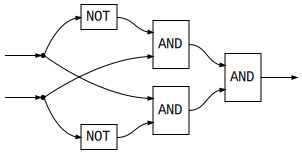

In [27]:
show_diagram(to_wiring_diagram(demo1))

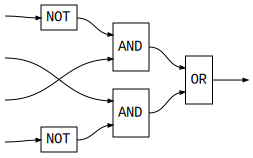

In [28]:
show_diagram(to_wiring_diagram(demo2))

Another way to see this: when we consider an equivalent $CNF$ formula to a circuit, we notice if a variable is never used more than once, then we can manipulate that variable's corresponding literal to output true, so we will have a conjunct of disjunct of trues. Note that our circuit models actually give a strong and more general statement than this, since circuits may have an array of outputs and $P_n$ is more general than just "satisfiable" anyway. The following shows that ```demo2``` is actually satisfiable and returns a true assignment to ```demo2```, note that having copy gates says nothing about satsfiability, so ```demo1``` not being satisfiable is only a coincidence. 

In [46]:
#brute force SAT algorithm, loops over all the possible inputs
#return true and first argument that gives true if sat., else returns false and the last argument
function brute_SAT(f::Circuit)
    sat = false
    i = 0
    dom = f.dom.n
    arr = Bool[]

    if !(f.codom == CircuitDom(1))
        error("circuit codomain needs to be 1!")
    else
        while (!sat)&&(i < 2^dom)
                arr = iszero.(digits(i, base=2, pad=dom))
                sat = f.impl(arr)[1]                
                i += 1
        end
        return (sat, arr)
    end
end

brute_SAT(expr) = brute_SAT(Impl(expr))

brute_SAT(demo1)

(false, Bool[0, 0])

In [47]:
brute_SAT(demo2)

(true, Bool[0, 1, 1, 1])

```brute_SAT(expr)``` returns a pair ```(x::Bool,y::BitVector)```, where ```x``` says whether ```expr``` is satisfiable, if so ```x == true``` and ```y``` is the first satisfying assignment it finds, if not then ```x == false```



Compologicircuits in fact has a function that takes in an expression of the type ```FreeCartesianCategory.Hom``` and returns an equivalent $CNF$ formula stored as a ector of vector of nonzero integers. Here is all the code to achieve this:

In [50]:
to_diagram(x) = add_junctions!(to_wiring_diagram(x))

normal_form(x) = to_hom_expr(FreeCartesianCategory, to_diagram(x))

#replacing all instances of i and j in v with r, ignoring but keeping their signs
function copy_replace(v::Vector, i::Int, j::Int, r::Int)
    count = 1
    for a in v
        if (abs(a) == abs(i)) || (abs(a) == abs(j))
            v[count] = Int((abs(a)/a)*abs(r))
        end
        count += 1
    end
    return v
end

#replace all instances of n with m, and m with n, at the same time, ignoring but keeping signs
function braid_replace(v::Vector, n::Int, m::Int)
    count = 1
    for i in v
        if abs(i) == abs(n)
            v[count] = Int((abs(i)/i)*abs(m))
        elseif abs(i) == abs(m)
            v[count] = Int((abs(i)/i)*abs(n))
        end
        count += 1
    end
    return v
end

#replace all instances of n or -n with its negation
function not_replace(v::Vector, n::Int)
    count = 1
    for i in v
        if abs(i) == abs(n)
            v[count] = -Int((abs(i)/i)*abs(n))
        end
        count += 1
    end
    return v
end

function populate(v::Vector, anc::Int, offs::Int)
    output = []
    for i in v
        if i != anc
            push!(output, i)
        else
            push!(push!(output, i), offs)
        end
    end
    return output
end

#get rid of all instances of n in v, except the first
function cleanse(v::Vector, n::Int)
    output = []
    found = false
    for i in v
        if i != n
            push!(output, i)
        elseif !found
            found = true
            push!(output, i)
        end
    end
    return output
end

function splate(v::Vector, old::Int, new::Int)
    temp =[]
    for i in v
        if i != old
            push!(temp, i)
        else
            push!(temp, new)
        end
    end
    if v == temp
        return [v]
    else
        return [v, temp]
    end
end

#apply the expression expr to the current cnf
#only works for expressions with no nested otimes, every exression is expressible without nested otimes
function app_expr(expr, vars::Vector, cnf::Vector, begn::Int, ed::Int)
    #assuming that if head(expr) == :otimes then no argument of expr has :otimes head
    #vars = the boolean variables on each wire in order, must all be positive
    #begn = which wire to begin applying expr in vars
    #ed = the number of input wires of the previous application, might not always be relevant
    
    out_vars = vars #the vars on the wires after applying expr
    out_cnf = cnf #cnf after applying expr
    out_begn = begn #which wire to start the next application, should always be 1
    out_ed = ed #the input wires of expr, might not always be relevant
    new_var = maximum(vars)+1 #only needed to introduce a new variable for and, or gates
    heads = head(expr)
    argss = args(expr)
    
    if heads == :compose
        for i in reverse(argss)
            (out_vars, out_cnf, out_begn, out_ed) = app_expr(i, out_vars, out_cnf, out_begn, out_ed)
        end
    elseif heads == :otimes
        #@assert begn == 1
        (out_vars, out_cnf, out_begn, out_ed) = app_expr(argss[1], out_vars, out_cnf, out_begn, out_ed)
        for i in argss[2:end]
            v = app_expr(i, out_vars, out_cnf, out_ed+1, out_ed)
            out_ed += v[4]
            out_vars = v[1]
            out_cnf = v[2]
        end
    #assume to be Δ(B)
    elseif heads == :mcopy
        n = max(vars[begn], vars[begn+1])
        out_cnf = map(x -> copy_replace(x, vars[begn], vars[begn+1], n), out_cnf)
        out_vars[begn] = n
        out_vars = out_vars[1:end .!= begn+1]
        out_ed = 1
    #assumed to be σ(B,B)
    elseif heads == :braid
        n = vars[begn]
        m = vars[begn+1]
        out_vars[begn] = m
        out_vars[begn+1] = n
        out_cnf = map(x -> braid_replace(x, n, m), out_cnf)
        out_ed = 2
    elseif heads == :id
        out_ed = Impl(expr).dom.n
    elseif expr == not
        var = out_vars[begn]
        out_ed = 1
        out_cnf = map(x -> not_replace(x, var), out_cnf)
    elseif expr == and
        var = vars[begn]
        out_vars = vcat(vcat(vars[1:begn], [new_var]), vars[begn+1:end])
        temp = Vector{Int}[]
        out_cnf = map(x -> cleanse(x, var), out_cnf)
        out_cnf = map(x -> cleanse(x, -var), out_cnf)
        for v in out_cnf
            if (!(var in v) && !(-var in v))
                push!(temp, v)
            else
                temp_v = populate(v, -var, -new_var)
                temp_v = splate(temp_v, var, new_var)
                temp = vcat(temp, temp_v)
            end
        end
        out_cnf = temp
        out_ed = 2   
    elseif expr == or
        var = vars[begn]
        out_vars = vcat(vcat(vars[1:begn], [new_var]), vars[begn+1:end])
        temp = Vector{Int}[]
        out_cnf = map(x -> cleanse(x, var), out_cnf)
        out_cnf = map(x -> cleanse(x, -var), out_cnf)
        for v in out_cnf
            if (!(var in v) && !(-var in v))
                push!(temp, v)
            else
                temp_v = populate(v, var, new_var)
                temp_v = splate(temp_v, -var, -new_var)
                temp = vcat(temp, temp_v)
            end
        end
        out_cnf = temp
        out_ed = 2
    end
    
    return (out_vars, out_cnf, out_begn, out_ed)  
end

function expr_to_cnf(expr)
    @assert Impl(expr).codom.n == 1 
    return app_expr(normal_form(expr), [1], [[1]], 1, 0)
end

expr_to_cnf (generic function with 1 method)

Let's see what the $CNF$'s of ```demo1``` and ```demo2``` are:

In [51]:
cnf1 = expr_to_cnf(demo1)

([2, 4], Vector{Any}[[-2], [2], [4], [-4]], 1, 2)

In [52]:
cnf2 = expr_to_cnf(demo2)

([1, 2, 3, 4], Vector{Any}[[-1, 3], [-1, -4], [2, 3], [2, -4]], 1, 4)

Note that the actual output is a tuple of size 4, the actual $CNF$ is the second element, the rest are parameters that are used in the implementation of the algorithm that uses recursive calls and its action depends on these parameters. The parameters are still meaningful, the following lists what they are

| ```expr_to_cnf(expr)```      | what is it? |
| :---        |    :----:   |
| 1st element      | the assignment of the variables on the input wires      |
| 2nd element   | equivalent $CNF$       |
| 3rd element   | where to start applying the input wires        |
| 4th element  | number of input wires        |

In [32]:
using PicoSAT
solution = PicoSAT.solve(cnf2[2])

4-element Vector{Int64}:
 -1
  2
  3
 -4

In [33]:
Impl(demo2).impl(map(x -> x > 0, solution))

1-element Vector{Bool}:
 1

As expected, the $CNF$ of ```demo1``` uses variables multiples times, but this is also true for ```demo2```, the reason is that it is merely _possible_ to express ```demo2``` with a $CNF$ that uses no variable more than once, however as we will see using a more conventional SAT solver PicoSAT, that ```cnf2[2]``` is satisfiable just like ```demo2```

The structure ```Augmented_Circuit``` has two fields, ```circ``` is the circuit and ```sol``` the "solution space" A.K.A. its truth table, consider the following two examples, demo2 indeed outputs ```true``` for input ```Bool[0,1,1,0]```

In [54]:
function all_inputs(n::Int)
    output = Vector{Vector{Bool}}()
    for i in 0:(2^n)-1
        vect = .!Vector{Bool}(iszero.(digits(i, base=2, pad=n)))
        push!(output, vect)
    end
    return output
end

struct Augmented_Circuit
    circ::Circuit
    sol::Vector{Vector{Vector{Bool}}} #array of type Vector{Vector{Vector{Bool}} matching input to output
end

Augmented_Circuit(c::Circuit) = begin
    n_ins = c.dom.n
    inputs = all_inputs(n_ins)
    truth_table = Vector{Vector{Vector{Bool}}}()
    for input in inputs
        output = c.impl(input)
        push!(truth_table, [input, output])
    end

    Augmented_Circuit(c, truth_table)
end

Augmented_Circuit((Impl(demo2))).sol

16-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0], [0]]
 [[1, 0, 0, 0], [0]]
 [[0, 1, 0, 0], [1]]
 [[1, 1, 0, 0], [1]]
 [[0, 0, 1, 0], [1]]
 [[1, 0, 1, 0], [0]]
 [[0, 1, 1, 0], [1]]
 [[1, 1, 1, 0], [1]]
 [[0, 0, 0, 1], [0]]
 [[1, 0, 0, 1], [0]]
 [[0, 1, 0, 1], [0]]
 [[1, 1, 0, 1], [0]]
 [[0, 0, 1, 1], [1]]
 [[1, 0, 1, 1], [0]]
 [[0, 1, 1, 1], [1]]
 [[1, 1, 1, 1], [0]]

In [55]:
tfba_ex = to_hom_expr(FreeCartesianCategory, total_four_bit_adder)
Augmented_Circuit(Impl(tfba_ex)).sol

512-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
 [[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1]]
 [[0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0]]
 [[1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1]]
 [[0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0]]
 [[1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1]]
 [[0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0]]
 [[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1]]
 [[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0]]
 [[1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1]]
 [[0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0]]
 [[1, 1, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1]]
 [[0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0]]
 ⋮
 [[0, 0, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0]]
 [[1, 0, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 1]]
 [[0, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0]]
 [[1, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1]]
 [[0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 0]]
 [[1, 0, 0, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 1]]
 [[0, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 0, 1,

Note that SAT and $CNF$ both make no sense for ```total_four_bit_adder```, so we get an error

In [56]:
brute_SAT(tfba_ex)

LoadError: circuit codomain needs to be 1!

In [57]:
expr_to_cnf(tfba_ex)

LoadError: AssertionError: (Impl(expr)).codom.n == 1

Just for fun, here's the truth table for a terrible terrible circuit

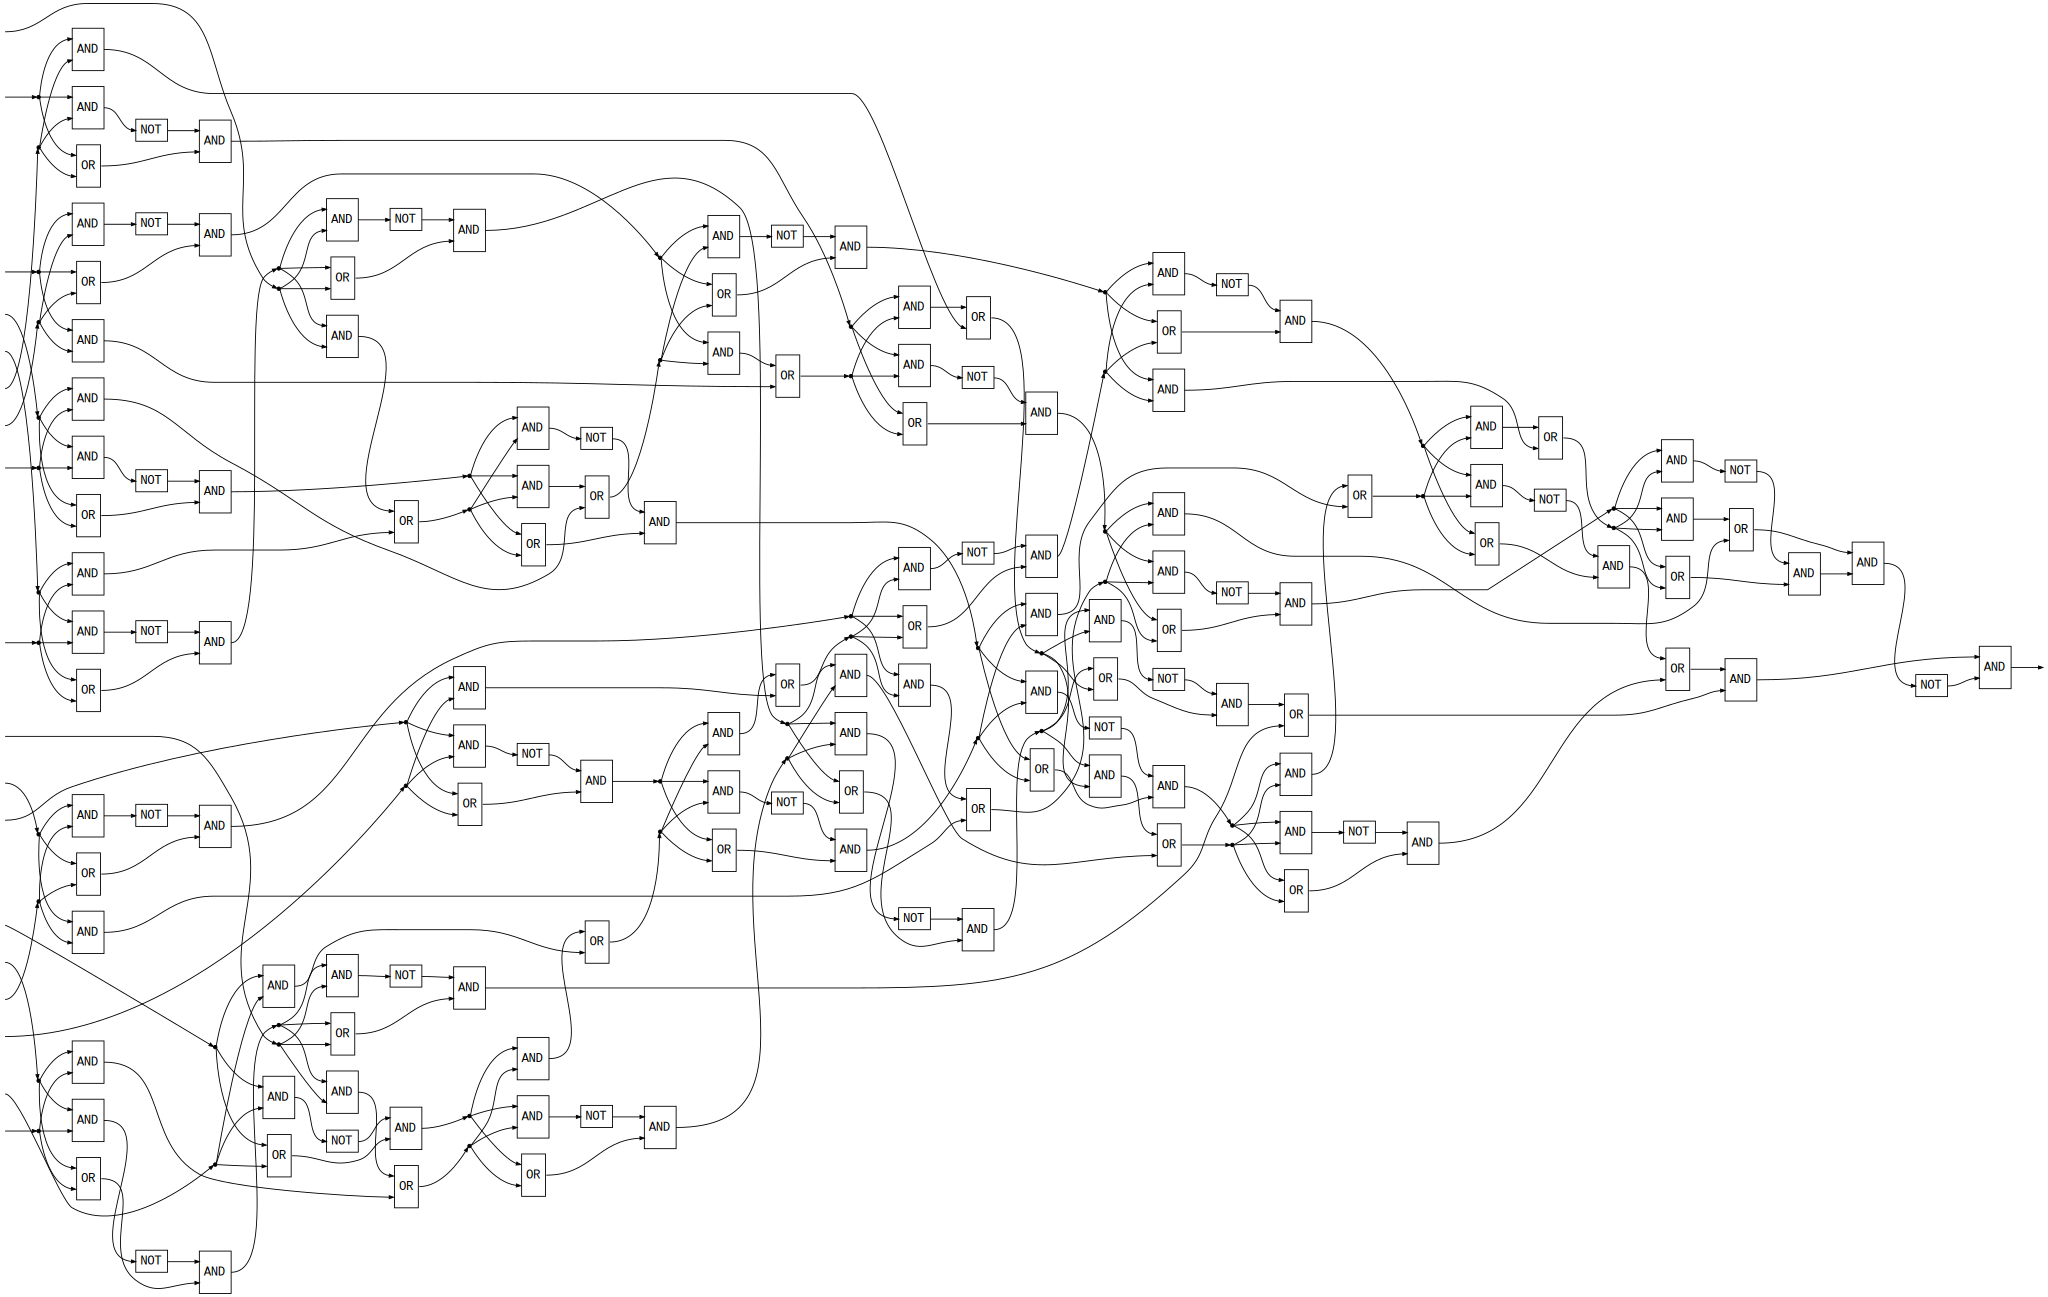

In [63]:
terror = (tfba_ex ⊗ tfba_ex) ⋅ (tfba_ex ⊗ id(B)) ⋅ (and⊗or⊗or) ⋅(σ(B, B⊗B)) ⋅ (and⊗not) ⋅ and
show_diagram(to_diagram(terror))

In [59]:
@time brute_SAT(terror)

  0.069503 seconds (394.40 k allocations: 14.556 MiB, 25.82% gc time, 69.49% compilation time)


(true, Bool[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [64]:
@time Augmented_Circuit(Impl(terror)).sol

106.410123 seconds (2.28 G allocations: 142.303 GiB, 16.88% gc time)


262144-element Vector{Vector{Vector{Bool}}}:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 [[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]
 [[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0]]
 ⋮
 [[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]
 [[0, 1

It wasn't that bad to find a satisfying assignment for ```terror```, but it was terrible to compute its truth table, because there are $2^{18} = 262144$ number of rows! Rather than storing this information as a truth table then, we can do a binary decision tree.